In [22]:
import cv2
import numpy as np

import torch
import matplotlib.pyplot as plt

from lib.data import CityscapesDataModule
from lib.models import Model


def process_mask(seg_mask, ds):
    colored_mask = np.zeros((512, 1024, 3), dtype=np.uint8)
    for id, color in enumerate(ds.color_palette):
        colored_mask[seg_mask == id] = ds.color_palette[color]
    return colored_mask


def process_bboxes(image, bboxes, labels, ds):
    for idx, bbox in enumerate(bboxes):
        bbox = bbox.numpy().astype(np.int32)
        label = ds.localization_class_names[labels[idx].item()]
        # color = ds.color_palette[11 + labels[idx].item()]
        color = (0, 0, 0)
        # print(label, color)

        image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 3)

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
        image = cv2.rectangle(
            image, (bbox[0], bbox[1] - h - 10), (bbox[0] + w, bbox[1]), color, -1
        )
        image = cv2.putText(
            image,
            label,
            (bbox[0], bbox[1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            [255, 255, 255],
            2,
        )
    return image


snapshot = torch.load(
    "exp/cityscapes_default_exp1/checkpoint-epoch=149-mIoU=0.70-map_50=0.50.ckpt"
)
print(snapshot["epoch"])

state_dict = {
    k.replace("model.", ""): v
    for k, v in snapshot["state_dict"].items()
    if k.startswith("model.")
}

model = Model(classification_classes=14, localization_classes=3, head_planes=256)
model.load_state_dict(state_dict)
model.eval()

dm = CityscapesDataModule(
    root="data/cityscapes", train_size=(512, 1024), test_size=(512, 1024)
)
dm.setup("evaluate")

with torch.no_grad():
    for idx, batch in enumerate(dm.val_dataloader()):
        if idx == 1:
            classification, centerness, regression = model(batch[0])
            seg_mask, detections = model.postprocess(
                classification,
                centerness,
                regression,
                bbox_down_stride=4,
                conf_th=0.35,
                topK=100,
            )
            break

149


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


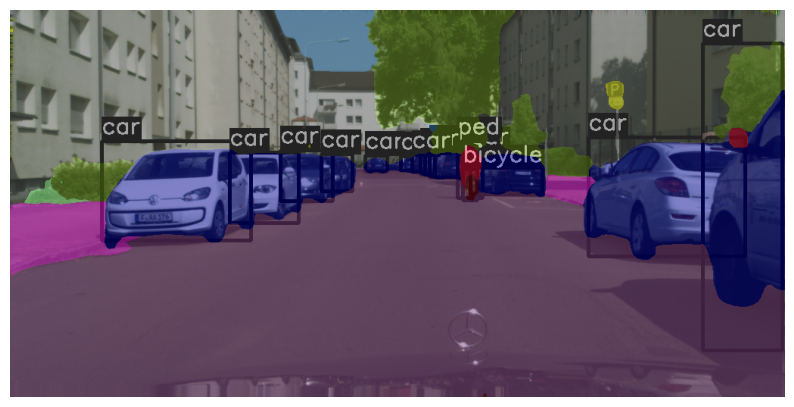

In [23]:
mask = process_mask(seg_mask[0], dm.val_dataset)
inv_image = batch[0][0].permute(1, 2, 0).numpy() * np.array(
    [0.229, 0.224, 0.225]
) + np.array([0.485, 0.456, 0.406])
final = process_bboxes(
    inv_image.copy(), detections[0][0], detections[0][2], dm.val_dataset
)

plt.figure(figsize=(10, 10))
plt.imshow(final)
plt.imshow(mask, alpha=0.5)
plt.axis("off")
plt.show()

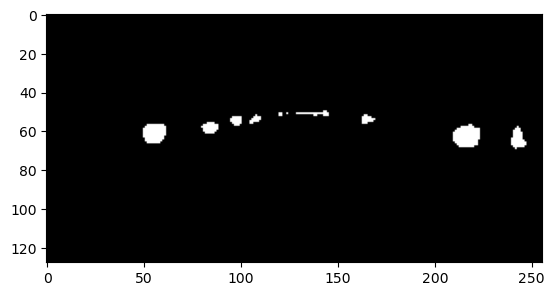

In [40]:
plt.imshow(centerness.sigmoid()[0][1] > 0.3, cmap="gray")

In [32]:
import torch
import onnx, onnxsim
from io import BytesIO

from lib.models import Model


class OnnxModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        classifier, centerness, regression = self.model(x)
        return classifier.argmax(dim=1, keepdims=True), centerness, regression


model = OnnxModel(
    Model(classification_classes=14, localization_classes=3, head_planes=256)
)
model.eval()

sample = torch.randn(1, 3, 384, 768)
input_names, output_names = ["input_tensor"], [
    "classification",
    "centerness",
    "regression",
]

onnx_path = "mtl_384x768_h256.onnx"
with BytesIO() as f:
    torch.onnx.export(
        model,
        sample,
        f,
        verbose=False,
        opset_version=11,
        training=torch.onnx.TrainingMode.EVAL,
        do_constant_folding=True,
        input_names=input_names,
        output_names=output_names,
    )
    f.seek(0)
    onnx_model = onnx.load(f)
    onnx.checker.check_model(onnx_model)

    try:
        onnx_model, check = onnxsim.simplify(onnx_model)
        assert check, "simplify check failed"
    except Exception as error:
        print(f"Simplifier failure: {error}")
onnx.save(onnx_model, onnx_path)

/media/ADAS1/Nisarg/paper-temp/lib/models/model.py:161: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  scale_factor=(int(x.size(2)), int(x.size(3))),


In [33]:
import torch
import lightning as L

from lib.core import MTL
from lib.data import CityscapesDataModule

snapshot = torch.load("exp/cityscapes_default_exp1/last.ckpt")

print(snapshot["epoch"])

dm = CityscapesDataModule(
    root="data/cityscapes",
    train_size=(512, 1024),
    test_size=(512, 1024),
    eval_transforms_kwargs={"min_area": 512},
)
dm.setup()

net = MTL(
    dm.val_dataset.classification_class_names,
    dm.val_dataset.localization_class_names,
    conf_th=0.3,
    head_planes=256,
)
net.load_state_dict(snapshot["state_dict"])
net.eval()

trainer = L.Trainer(accelerator="gpu", logger=None, enable_model_summary=True)
trainer.validate(net, datamodule=dm)

Trainer will use only 1 of 6 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=6)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


134
                                                                          

╒═══════════════╤════════════════╤════════╤═════════════╤══════════╤════════════╕
│ CLASS NAMES   │   CLASS_WEIGHT │ IOU    │ PRECISION   │ RECALL   │ F1_SCORE   │
╞═══════════════╪════════════════╪════════╪═════════════╪══════════╪════════════╡
│ road          │       0.380982 │ 96.96% │ 98.37%      │ 98.55%   │ 98.46%     │
├───────────────┼────────────────┼────────┼─────────────┼──────────┼────────────┤
│ sidewalk      │       0.05419  │ 76.97% │ 87.81%      │ 86.17%   │ 86.98%     │
├───────────────┼────────────────┼────────┼─────────────┼──────────┼────────────┤
│ building      │       0.212968 │ 88.54% │ 94.95%      │ 92.92%   │ 93.92%     │
├───────────────┼────────────────┼────────┼─────────────┼──────────┼────────────┤
│ wall          │       0.007006 │ 39.48% │ 76.24%      │ 45.02%   │ 56.61%     │
├───────────────┼────────────────┼────────┼─────────────┼──────────┼────────────┤
│ fence         │ 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mIoU            │    0.6993025541305542     │
│          map_50           │    0.5132143497467041     │
│         val_loss          │    0.6802729368209839     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.6802729368209839,
  'map_50': 0.5132143497467041,
  'mIoU': 0.6993025541305542}]

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from lib.data import CityscapesDataModule


dm = CityscapesDataModule(root="data/cityscapes")
dm.setup("fit")

for batch in dm.val_dataloader():
    _, _, _, labels, heatmaps, _ = batch
    break

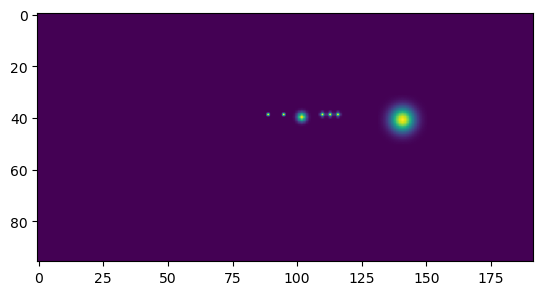

In [2]:
plt.imshow(heatmaps[0][0])